# Load checkpoint and imports

In [1]:
import os
import sys
parent_dir = "/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024"
# parent_dir="/Volumes/work/phd/MoLFormer_N2024"
sys.path.append(parent_dir)
parent_dir="/Midgard/home/farzantn/mambaforge/envs/MolTran_CUDA11_cuda/lib/python3.8"
sys.path.append(parent_dir)

In [2]:
import warnings
device_name='cuda'
from argparse import Namespace
import yaml
import os
print(os.getcwd())

warnings.filterwarnings('ignore')
from utils.gs_lf import *
with open('../custom_utils/hparams.yaml', 'r') as f:
    config = Namespace(**yaml.safe_load(f))

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 35
plt.rcParams["figure.figsize"] = (10,10)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from utils.prepare_datasets import *
from utils.helper_methods import *
from constants import *


/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024/Notebooks
/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024/Notebooks


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Midgard/home/farzantn/mambaforge/envs/Mol/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
base_path  = '../../../../T5 EVO/alignment_olfaction_datasets/'
base_path = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/'

In [4]:
! ls '../../../..'

DL				   eegnet_pytorch.yml  new_projects  tmp
Data				   envs		       nltk_data     work
Midgard				   erpenet8.yml        nohup.out
Miniconda3-latest-Linux-x86_64.sh  mambaforge	       phd
curated_datasets		   miniconda3	       projects


In [5]:
seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

# helper methods

In [6]:
def mAP(targs, preds, pos_thr=0.5):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """
    def average_precision(output, target):
        epsilon = 1e-8

        # sort examples
        indices = output.argsort()[::-1]
        # Computes prec@i
        total_count_ = np.cumsum(np.ones((len(output), 1)))

        target_ = target[indices]
        ind = target_ == 1
        pos_count_ = np.cumsum(ind)
        total = pos_count_[-1]
        pos_count_[np.logical_not(ind)] = 0
        pp = pos_count_ / total_count_
        precision_at_i_ = np.sum(pp)
        precision_at_i = precision_at_i_ / (total + epsilon)

        return precision_at_i

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        scores = preds[:, k]
        targets = targs[:, k]
        ap[k] = average_precision(scores, targets)
    tp, fp, fn, tn = [], [], [], []
    conf_matrices = []

    for k in range(preds.shape[0]):
        scores = preds[k,:]
        targets = targs[k,:]
        pred = (scores > pos_thr).astype(np.int32)
        tp.append(((pred + targets) == 2).sum())
        fp.append(((pred - targets) == 1).sum())
        fn.append(((pred - targets) == -1).sum())
        tn.append(((pred + targets) == 0).sum())
        conf_matrices.append(confusion_matrix(targets, pred))

    p_c = [tp[i] / (tp[i] + fp[i]) if tp[i] > 0 else 0.0 for i in range(len(tp))]
    r_c = [tp[i] / (tp[i] + fn[i]) if tp[i] > 0 else 0.0
                for i in range(len(tp))]
    f_c = [2 * p_c[i] * r_c[i] / (p_c[i] + r_c[i]) if tp[i] > 0 else 0.0
                for i in range(len(tp))]

    mean_p_c = sum(p_c) / len(p_c)
    mean_r_c = sum(r_c) / len(r_c)
    mean_f_c = sum(f_c) / len(f_c)

    p_o = sum(tp) / (np.array(tp) + np.array(fp)).sum()
    r_o = sum(tp) / (np.array(tp) + np.array(fn)).sum()
    f_o = 2 * p_o * r_o / (p_o + r_o)
    # roc_auc=roc_auc_score(targs, preds)
    roc_auc_score_test = roc_auc_score(targs,
    preds,
    multi_class="ovr",
    average="micro")
    # cm =multilabel_confusion_matrix(targets, pred)

    # for i in range(targets.shape[1]):
        

    return ap.mean(), mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc_score_test


In [13]:
def train_and_eval(gs_lf_embeddings_train,gs_lf_embeddings_valid,gs_lf_embeddings_test,gs_lf_y_train,gs_lf_y_valid,gs_lf_y_test,plot=True):
    gs_lf_embeddings_train_valid = np.vstack((gs_lf_embeddings_train,gs_lf_embeddings_valid))
    gs_lf_y_train_valid = np.vstack((gs_lf_y_train,gs_lf_y_valid))
    
    linreg,X_test,var = pipeline_regression(gs_lf_embeddings_train_valid,gs_lf_y_train_valid,gs_lf_embeddings_test,custom_logistic_regression,seed,n_components=None)
    predicted_probs = linreg.predict_proba(X_test)
    
    
    ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices,roc_auc = mAP(gs_lf_y_test, predicted_probs, pos_thr=0.5)
        
    
    if plot:
        all_fpr = []
        all_tpr = []
        all_roc_auc = []
        #todo: fix this gs_lf_y_train_valid vs gs_lf_y_test
        for j in range(gs_lf_y_train_valid.shape[1]):
            fpr, tpr, _ = roc_curve(gs_lf_y_test[:, j], predicted_probs[:, j])
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(auc(fpr, tpr))
        
        # Compute micro-average ROC curve and ROC area
        all_fpr = np.concatenate(all_fpr)
        all_tpr = np.concatenate(all_tpr)
        mean_fpr = np.linspace(0, 1, 5000)
        mean_tpr = np.interp(mean_fpr, all_fpr, all_tpr)
        mean_tpr[0] = 0.0
        mean_tpr[-1] = 1.0
        return ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc, mean_fpr, mean_tpr
    

    return ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc

In [9]:
def only_eval(gs_lf_y_test, predicted_probs,plot=True ):
    # Compute ROC curve and ROC area for each class
    ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices,roc_auc  = mAP(gs_lf_y_test, predicted_probs, pos_thr=0.5)
    
    if plot:
        all_fpr = []
        all_tpr = []
        all_roc_auc = []
        for j in range(gs_lf_y_test.shape[1]):
            fpr, tpr, _ = roc_curve(gs_lf_y_test[:, j], predicted_probs[:, j])
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(auc(fpr, tpr))
        
        # Compute micro-average ROC curve and ROC area
        all_fpr = np.concatenate(all_fpr)
        all_tpr = np.concatenate(all_tpr)
        mean_fpr = np.linspace(0, 1, 5000)
        mean_tpr = np.interp(mean_fpr, all_fpr, all_tpr)
        mean_tpr[0] = 0.0
        mean_tpr[-1] = 1.0
    
        return ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc, mean_fpr, mean_tpr
    return ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc

In [11]:

def plot_roc_auc_mean(base_path,index,data,color,x_att,y_att,train=True,fineTune=False,ds='alva'):
    mean_fpr = np.linspace(0, 1, 5000)
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(10, 10)) 
    
    
    for i in range(1,31):    
        input_file_indices = index+str(i)+'.csv'
        indices_train,indices_valid,indices_test = extract_set_idxs(base_path, indices_path=input_file_indices)
    
        if train and not fineTune: 
        
            input_file_data = data+'_Apr17.csv'
            
        elif train and fineTune:
           input_file_data = data+'_model_'+str(i)+'_Apr17.csv'
        
        else:
            input_file_data = data+str(i)+'_Apr17.csv'
        
        
        print(input_file_data)
            
            
        gs_lf, gs_lf_np,gs_lf_y,gs_lf_embeddings_train,gs_lf_y_train,gs_lf_embeddings_valid,gs_lf_y_valid,gs_lf_embeddings_test,gs_lf_y_test = extract_set_from_indices(base_path,input_file_data ,x_att,y_att, indices_train, indices_valid, indices_test)
        
        #remove columns where all values are zero in following numpy arrays
        gs_lf_np = gs_lf_np[:,~np.all(gs_lf_np == 0, axis=0)]
        gs_lf_embeddings_train = gs_lf_embeddings_train[:,~np.all(gs_lf_embeddings_train == 0, axis=0)]
        gs_lf_embeddings_valid = gs_lf_embeddings_valid[:,~np.all(gs_lf_embeddings_valid == 0, axis=0)]
        gs_lf_embeddings_test = gs_lf_embeddings_test[:,~np.all(gs_lf_embeddings_test == 0, axis=0)]
        
        if train:
            ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc, fpr, tpr = train_and_eval(gs_lf_embeddings_train,gs_lf_embeddings_valid,gs_lf_embeddings_test,gs_lf_y_train,gs_lf_y_valid,gs_lf_y_test)
        else:
            print(gs_lf_y_test.shape, gs_lf_embeddings_test.shape)
            ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,conf_matrices, roc_auc, fpr, tpr = only_eval( gs_lf_y_test, gs_lf_embeddings_test)

        
        tprs.append(tpr)
        aucs.append(roc_auc)
        print(roc_auc)
    
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='')
    
    
    # Calculate the mean and standard deviation of the TPRs
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=7, alpha=.8)
    
    # Calculate the standard deviation of the TPRs
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Fill the area between the TPRs
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
    
    # Plot chance level
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Micro-averaged ROC Curve with Mean and SE')
    plt.legend(loc="lower right")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    print(labels)
    fig.subplots_adjust(bottom=0,left=0.1,right=0.95,top=0.7)
    # labels = ['MoLFormer', 'POM']
    ax.legend(handles, labels, ncol=2, columnspacing=1, prop={'size': 30}, handlelength=1.5, loc="lower center",
               borderpad=0.3,
               
               bbox_to_anchor=(0.5, -0.3), 
               
               frameon=True, labelspacing=0.4,handletextpad=0.2,)
    # plt.legend(title='Smoker', loc='upper left',)

    plt.tight_layout()

    fig.savefig(ds+".pdf", bbox_inches='tight')
    
    plt.show()

# Training Classifiers using DeepChem 

### Linear and Plot

FileNotFoundError: [Errno 2] No such file or directory: '../../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx-1.csv'

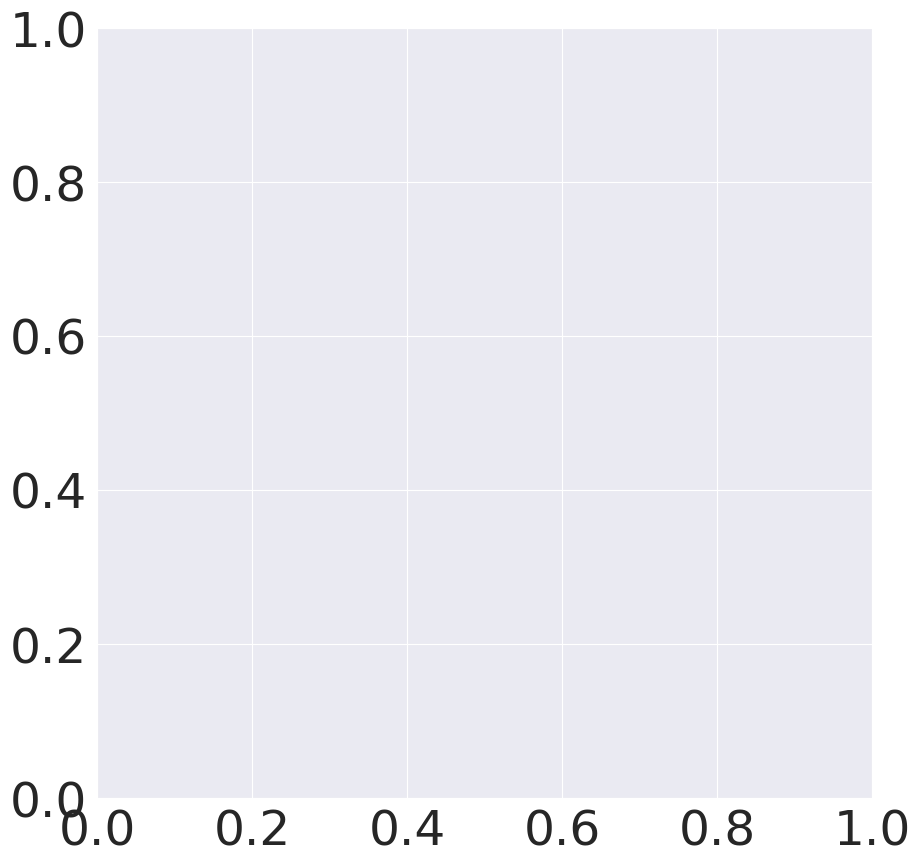

In [25]:
input_file_indices = 'curated_datasets/embeddings/pom/gslf-splits-idx-'
input_file_data = 'curated_datasets/embeddings/pom/gslf_pom_proba_' 
plot_roc_auc_mean(base_path,input_file_indices,input_file_data,x_att='embeddings',y_att='y',color='#ecc947',train=False,ds="pom_rocauc")

In [ ]:
input_file_indices = 'curated_datasets/embeddings/pom/gslf-splits-idx-'
input_file_data = 'curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13'    
plot_roc_auc_mean(base_path,input_file_indices,input_file_data,color='#4d79a4',x_att='embeddings',y_att='y',train=True,ds="molformerfinetuned_rocauc")

In [ ]:
input_file_indices = 'curated_datasets/embeddings/pom/gslf-splits-idx-'
input_file_data = 'curated_datasets/embeddings/molformerfinetuned/gslf_molformerfinetuned_embeddings_13'     
plot_roc_auc_mean(base_path,input_file_indices,input_file_data,color='#4d79a4',x_att='embeddings',y_att='y',train=True,fineTune=True,ds="molformer_rocauc")

curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4484, 15) (4484, 138) (499, 15)
0.8684853508444417
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4479, 15) (4479, 138) (504, 15)
0.8694320872128386
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4490, 15) (4490, 138) (493, 15)
0.8763712782751892
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4482, 15) (4482, 138) (501, 15)
0.8672592092701762
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4483, 15) (4483, 138) (500, 15)
0.8733164139950952
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4499, 15) (4499, 138) (484, 15)
0.8710962643909695
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4475, 15) (4475, 138) (508, 15)
0.8763362514460009
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee (4491, 15) (4491, 138) (492, 15)
0.8702818148076885
curated_datasets/alva/gslf_molecules_alva_y_Apr17.csv
shapeeeeee

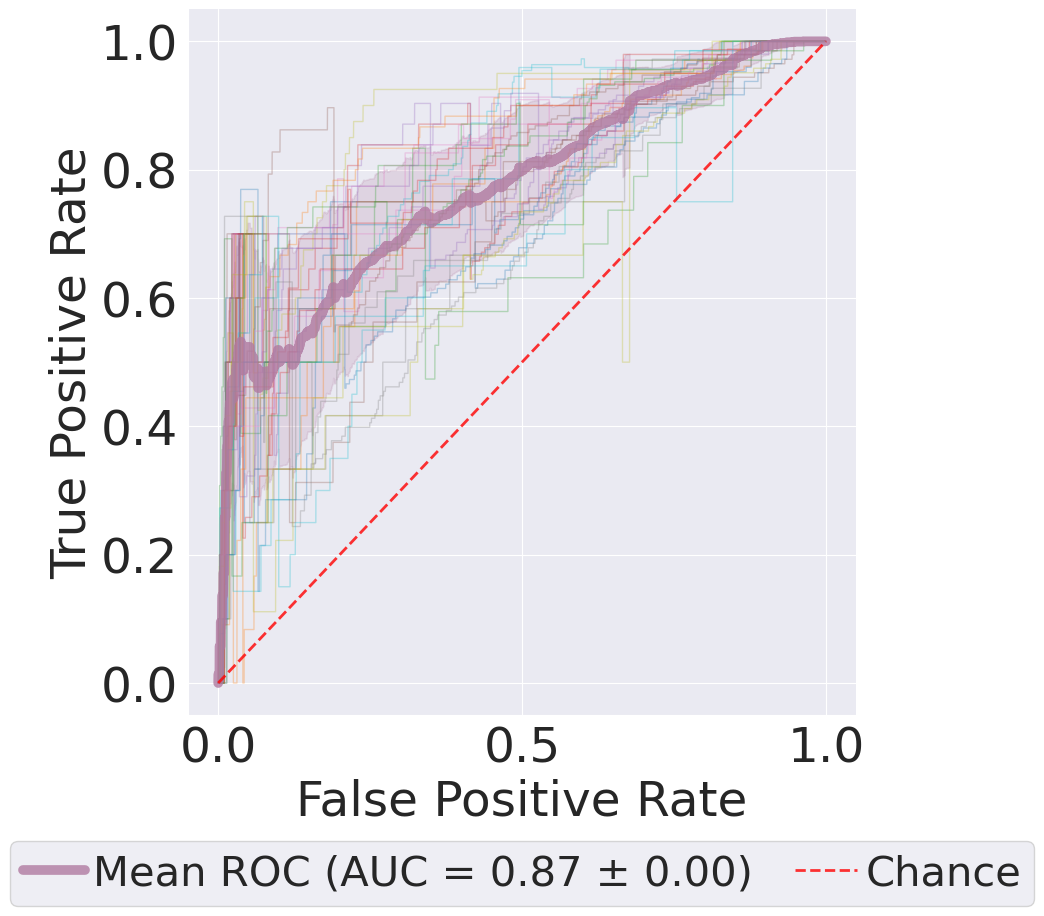

In [14]:
input_file_indices = 'curated_datasets/embeddings/pom/gslf-splits-idx-'
input_file_data = 'curated_datasets/alva/gslf_molecules_alva_y'      
plot_roc_auc_mean(base_path,input_file_indices,input_file_data,color='#b07aa0',x_att='embeddings',y_att='y',train=True,ds="DAM_rocauc")

In [ ]:
input_file_data = 'curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13'     
df_gslf = pd.read_csv(base_path+input_file_data+'_Apr17.csv').columns.values.tolist()